In [7]:
from brian2 import *
import numpy as np

start_scope()

defaultclock.dt = 0.0001*ms  

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    return np.tanh(w * x)
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    #print(spikes_received, sum)
    return (sum/spikes_received)+ layer



def mini1x1x1(inputs, w1, w2):
    """
    Mini 1x1x1 network with a single input, hidden, and output neuron.
    This is a minimal example to demonstrate the basic structure of a spiking neural network.
    """
    # Define network sizes
    n_input = 1
    n_hidden = 1
    n_output = 1
    n_total = n_input + n_hidden + n_output

    # Full neuron group
    neurons = NeuronGroup(n_total, '''
        v : 1
        sum : 1
        spikes_received : 1
        scheduled_time : second
        global_clock : 1
    ''', threshold='v > 1', reset='v = 0', method='exact')

    neurons.v = 0
    neurons.scheduled_time = 1e9 * second
    neurons.global_clock = 0.0
    neurons.sum = 0.0
    neurons.spikes_received = 0.0

    # Spike inputs (one per input neuron)     
    stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=(inputs) * ms)

    # Input → Hidden connections
    syn_input = Synapses(stim, neurons[0:n_input], '''
        w : 1
        layer : 1
    ''', on_pre='''
        spikes_received += 1
        sum += spike_timing(w, global_clock, layer, spikes_received, sum)
        scheduled_time = ((sum/spikes_received) + layer) * ms 
    ''')
    syn_input.connect(j='i')  # connect stim[i] to neurons[i]
    syn_input.layer = 0

    # Hidden layer: input → hidden
    syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
        w : 1
        layer : 1
    ''', on_pre='''
        spikes_received += 1
        sum += spike_timing(w, global_clock, layer, spikes_received, sum)
        scheduled_time = ((sum/spikes_received) + layer) * ms 
    ''')
    syn_hidden.connect()
    syn_hidden.w = w1 
    syn_hidden.layer = 1

    # Output layer: hidden → output
    syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
        w : 1
        layer : 1
    ''', on_pre='''
        spikes_received += 1
        sum += spike_timing(w, global_clock, layer, spikes_received, sum)
        scheduled_time = ((sum/spikes_received) + layer) * ms 
    
    ''')
    syn_output.connect()
    syn_output.w = w2 
    syn_output.layer = 2

    neurons.run_regularly('''
        v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
                        
        global_clock += 0.001
    ''', dt=0.001*ms)



    # Monitors
    mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
    mon_sum = StateMonitor(neurons, 'sum', record=True)
    sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
    sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


    spikemon = SpikeMonitor(neurons)


    run(5*ms)

    # # Plot voltages
    figure(figsize=(10, 6))
    for i in range(n_total):  # All neurons
        plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    #plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
    print(mon_sum.sum[1])
    print(sp_mon.spikes_received[1])
    print(sch_time.scheduled_time[1])

    for i in range(n_total):
        times = spikemon.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron {i} spike times: {formatted_times}")

            
    return mon_sum.sum, sp_mon.spikes_received






WARNING    'sum' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value array([[0.       , 0.       , 0.       , ..., 0.951    , 0.951    ,
        0.951    ],
       [0.       , 0.       , 0.       , ..., 1.       , 1.       ,
        1.       ],
       [0.       , 0.       , 0.       , ..., 0.9332543, 0.9332543,
        0.9332543]]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    'sum' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value array([[0.       , 0.       , 0.       , ..., 0.951    , 0.951    ,
        0.951    

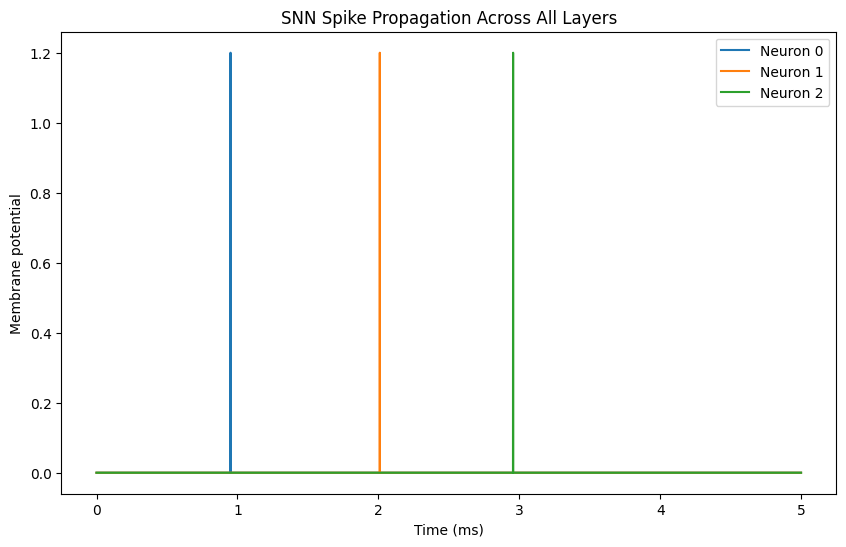

[0.        0.        0.        ... 1.0098866 1.0098866 1.0098866]
[0. 0. 0. ... 1. 1. 1.]
[1.0000000e+06 1.0000000e+06 1.0000000e+06 ... 2.0098866e-06 2.0098866e-06
 2.0098866e-06] ks
Neuron 0 spike times: ['0.951 ms']
Neuron 1 spike times: ['2.010 ms']
Neuron 2 spike times: ['2.956 ms']


In [6]:
inputs = np.array([0.95])
w_1 = np.array([1.2])
w_2 = np.array([0.99])
sum, spikes_received = mini1x1x1(inputs, w_1, w_2)